# Hotel Upsell Revenue Analysis Plan

## Major Assumptions
We assume the upsell_transactions table contains transaction-level data with revenue amounts and property identifiers, and the properties table includes hotel segment classifications. Incremental revenue refers to the additional revenue generated from upsell transactions beyond base bookings. We'll aggregate at the property level first, then summarize by segment to understand performance patterns across different hotel categories.

## Plan
- [x] Query and aggregate upsell revenue data by property and segment
  - [x] Join upsell_transactions with properties table and calculate total incremental revenue per property
  - [x] Compute average incremental revenue per property within each hotel segment
- [x] Visualize and interpret segment performance
  - [x] Create bar chart comparing average incremental revenue across hotel segments
  - [x] Identify top and bottom performing segments with key insights
- [x] Analyze mobile check-in adoption by brand partner
  - [x] Query checkin_events to calculate mobile vs total check-ins per property and brand
  - [x] Visualize adoption rates by brand partner with color-coded performance tiers
  - [x] Identify lagging properties with below-average adoption rates
- [x] Analyze AI Voice performance since launch
  - [x] Query voice_calls for call volume, resolution status, guest satisfaction
  - [x] Calculate monthly trends and overall KPIs
  - [x] Create 4-panel dashboard: volume, resolution rate, satisfaction, by call type

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine

# SignalPilot dark theme
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Canary Technologies database
engine = create_engine(os.environ['CANARY_TECHNOLOGIES_CONNECTION_URL'])

# Query: Average incremental revenue per property by hotel segment
query = """
SELECT 
    p.hotel_segment,
    p.id AS property_id,
    p.property_name,
    COALESCE(SUM(u.amount_usd), 0) AS total_upsell_revenue
FROM public.properties p
LEFT JOIN public.upsell_transactions u ON p.id = u.property_id
WHERE p.has_upsell = TRUE
GROUP BY p.hotel_segment, p.id, p.property_name
"""

df_property = pd.read_sql(query, engine)
engine.dispose()

print(f"Properties with upsell enabled: {df_property['property_id'].nunique()}")
print(f"Hotel segments: {df_property['hotel_segment'].nunique()}")
df_property.head()

Properties with upsell enabled: 312
Hotel segments: 4


,hotel_segment,property_id,property_name,total_upsell_revenue
0,upper_upscale,1045,Pullman Indianapolis Galleria,12255.95
1,luxury,1040,The Ritz Park City University,127492.75
2,midscale,1308,Best Western Plus Fresno Convention Center,5601.80
3,upscale,1151,Delta Hotels Aspen Waterfront,17522.87
4,upper_upscale,1092,InterContinental San Francisco Midtown,97297.34


In [2]:
# Calculate average incremental revenue per property by hotel segment
df_segment = df_property.groupby('hotel_segment').agg(
    num_properties=('property_id', 'count'),
    avg_revenue_per_property=('total_upsell_revenue', 'mean'),
    total_segment_revenue=('total_upsell_revenue', 'sum'),
    median_revenue=('total_upsell_revenue', 'median')
).reset_index()

# Sort by average revenue descending
df_segment = df_segment.sort_values('avg_revenue_per_property', ascending=False)

# Format for display
df_segment['avg_revenue_per_property'] = df_segment['avg_revenue_per_property'].round(2)
df_segment['total_segment_revenue'] = df_segment['total_segment_revenue'].round(2)
df_segment['median_revenue'] = df_segment['median_revenue'].round(2)

df_segment

,hotel_segment,num_properties,avg_revenue_per_property,total_segment_revenue,median_revenue
0,luxury,34,81066.70,2756267.68,80855.82
2,upper_upscale,73,50383.95,3678028.15,51407.59
3,upscale,117,29704.08,3475377.83,28754.51
1,midscale,88,15665.42,1378556.53,15533.68


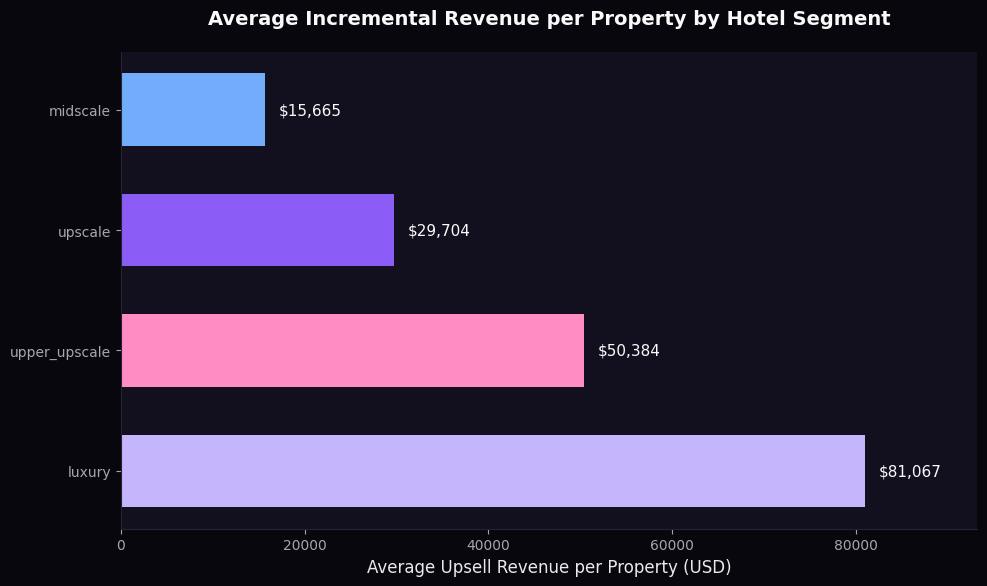

In [3]:
# Visualize average incremental revenue per property by hotel segment
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(df_segment['hotel_segment'], df_segment['avg_revenue_per_property'], 
               color=CATEGORICAL_PALETTE[:len(df_segment)], height=0.6)

# Add value labels
for bar, val in zip(bars, df_segment['avg_revenue_per_property']):
    ax.text(val + 1500, bar.get_y() + bar.get_height()/2,
           f'${val:,.0f}', va='center', fontsize=11, color='#FAFAFA')

ax.set_xlabel('Average Upsell Revenue per Property (USD)')
ax.set_title('Average Incremental Revenue per Property by Hotel Segment', fontweight='bold', pad=20)
ax.set_xlim(0, df_segment['avg_revenue_per_property'].max() * 1.15)

plt.tight_layout()
plt.show()

In [4]:
# Query mobile check-in adoption by brand partner
engine = create_engine(os.environ['CANARY_TECHNOLOGIES_CONNECTION_URL'])

query_adoption = """
SELECT 
    bp.brand_name,
    p.id AS property_id,
    p.property_name,
    p.has_mobile_checkin,
    COUNT(ce.id) AS total_checkins,
    SUM(CASE WHEN ce.checkin_method = 'mobile' THEN 1 ELSE 0 END) AS mobile_checkins
FROM public.properties p
JOIN public.brand_partners bp ON p.brand_partner_id = bp.id
LEFT JOIN public.checkin_events ce ON p.id = ce.property_id
WHERE p.status = 'active'
GROUP BY bp.brand_name, p.id, p.property_name, p.has_mobile_checkin
"""

df_checkin = pd.read_sql(query_adoption, engine)
engine.dispose()

# Calculate adoption rate
df_checkin['mobile_adoption_rate'] = (df_checkin['mobile_checkins'] / df_checkin['total_checkins'] * 100).round(2)
df_checkin['mobile_adoption_rate'] = df_checkin['mobile_adoption_rate'].fillna(0)

print(f"Active properties: {len(df_checkin)}")
print(f"Brand partners: {df_checkin['brand_name'].nunique()}")
df_checkin.head()

Active properties: 327
Brand partners: 25


,brand_name,property_id,property_name,has_mobile_checkin,total_checkins,mobile_checkins,mobile_adoption_rate
0,Accor,1008,The St. Regis Albuquerque Downtown,True,306,263,85.95
1,Accor,1014,Waldorf Astoria Los Angeles Medical Center,True,287,203,70.73
2,Accor,1015,The Peninsula San Antonio Historic District,True,364,256,70.33
3,Accor,1019,The Langham Minneapolis Riverwalk,False,220,0,0.00
4,Accor,1028,Four Seasons Pittsburgh University,True,105,11,10.48


In [5]:
# Aggregate mobile check-in adoption by brand partner
df_brand = df_checkin.groupby('brand_name').agg(
    num_properties=('property_id', 'count'),
    total_checkins=('total_checkins', 'sum'),
    mobile_checkins=('mobile_checkins', 'sum'),
    properties_with_mobile=('has_mobile_checkin', 'sum')
).reset_index()

df_brand['adoption_rate'] = (df_brand['mobile_checkins'] / df_brand['total_checkins'] * 100).round(1)
df_brand['feature_enabled_pct'] = (df_brand['properties_with_mobile'] / df_brand['num_properties'] * 100).round(1)
df_brand = df_brand.sort_values('adoption_rate', ascending=False)

df_brand[['brand_name', 'num_properties', 'adoption_rate', 'feature_enabled_pct']]

,brand_name,num_properties,adoption_rate,feature_enabled_pct
6,Highgate Hotels,6,84.0,100.0
13,Marriott International,46,78.4,100.0
7,Hilton Worldwide,36,77.7,100.0
12,Loews Hotels,8,76.8,100.0
23,Vail Hospitality,3,75.8,100.0
15,NH Hotel Group,4,71.5,100.0
10,Kimpton Hotels,6,68.9,100.0
3,Choice Hotels,19,65.3,89.5
5,Graduate Hotels,6,64.8,100.0
1,Aimbridge Hospitality,13,63.8,84.6


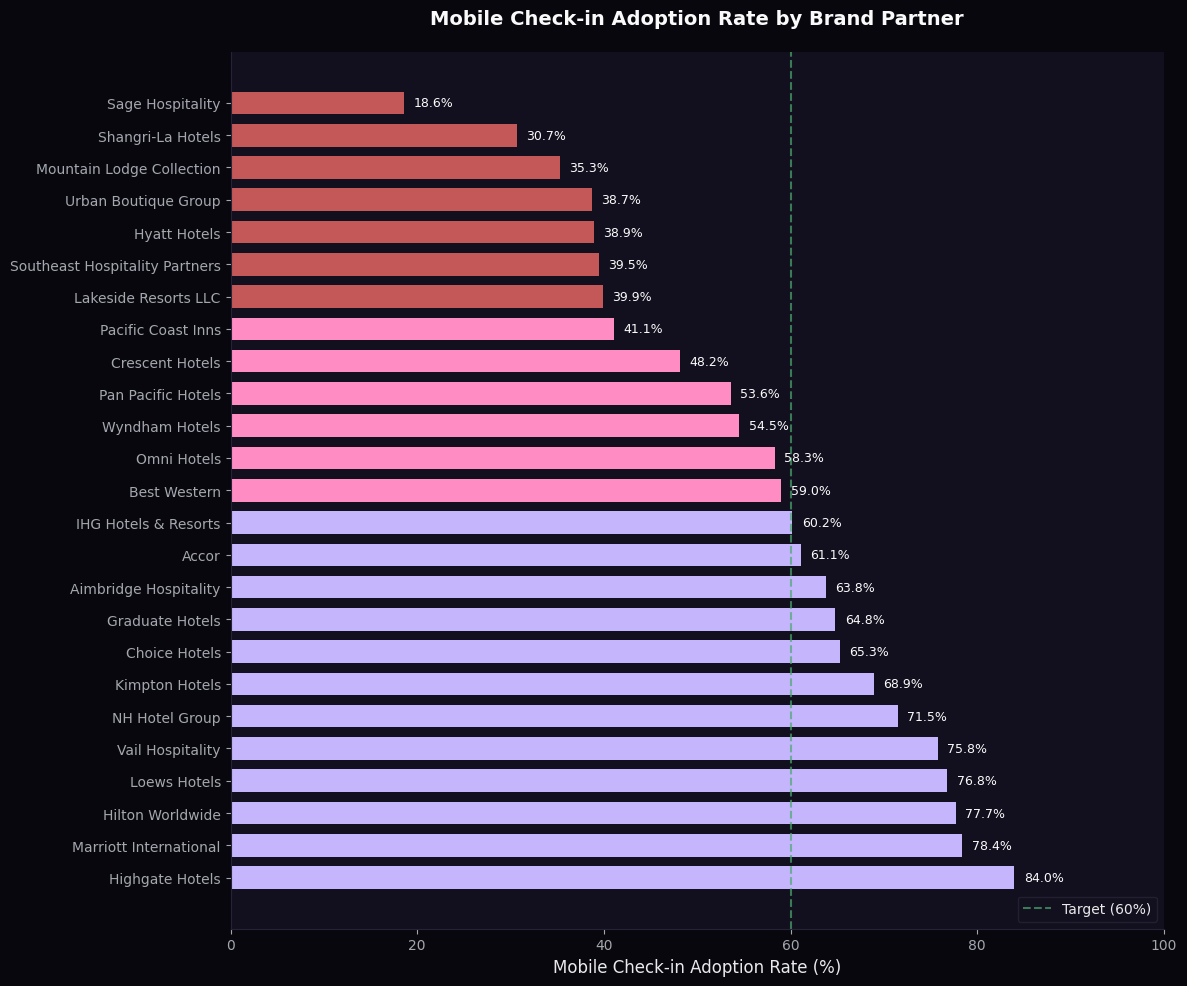

In [7]:
# Visualize mobile check-in adoption by brand partner
fig, ax = plt.subplots(figsize=(12, 10))

# Color coding: purple (good >=60%), pink (moderate 40-60%), red (lagging <40%)
colors = [COLORS['primary'] if rate >= 60 else COLORS['secondary'] if rate >= 40 else '#c45757' 
          for rate in df_brand['adoption_rate']]

bars = ax.barh(df_brand['brand_name'], df_brand['adoption_rate'], color=colors, height=0.7)

# Add value labels
for bar, val in zip(bars, df_brand['adoption_rate']):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2,
           f'{val:.1f}%', va='center', fontsize=9, color='#FAFAFA')

ax.axvline(x=60, color='#4ca86f', linestyle='--', linewidth=1.5, alpha=0.7, label='Target (60%)')
ax.set_xlabel('Mobile Check-in Adoption Rate (%)')
ax.set_title('Mobile Check-in Adoption Rate by Brand Partner', fontweight='bold', pad=20)
ax.set_xlim(0, 100)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [8]:
# Identify lagging properties (below 40% adoption with mobile check-in enabled)
overall_avg = df_checkin[df_checkin['has_mobile_checkin'] == True]['mobile_adoption_rate'].mean()

df_lagging = df_checkin[
    (df_checkin['has_mobile_checkin'] == True) & 
    (df_checkin['mobile_adoption_rate'] < 40) &
    (df_checkin['total_checkins'] >= 50)  # Exclude low-volume properties
].sort_values('mobile_adoption_rate')[['brand_name', 'property_name', 'total_checkins', 'mobile_adoption_rate']]

print(f"Overall average adoption (feature enabled): {overall_avg:.1f}%")
print(f"\nLagging properties (<40% adoption with 50+ check-ins): {len(df_lagging)}\n")
df_lagging.head(15)

Overall average adoption (feature enabled): 67.5%

Lagging properties (<40% adoption with 50+ check-ins): 29



,brand_name,property_name,total_checkins,mobile_adoption_rate
152,IHG Hotels & Resorts,Loews Santa Monica Historic District,182,8.24
310,Wyndham Hotels,AmericInn San Diego & Conference Center,77,9.09
29,Best Western,Courtyard by Marriott Orlando Downtown,170,9.41
137,Hyatt Hotels,Hilton Garden Inn Charleston Historic District,159,9.43
132,Hyatt Hotels,Residence Inn Fresno Galleria,147,9.52
250,Omni Hotels,Conrad Indianapolis Midtown,105,9.52
78,Graduate Hotels,SpringHill Suites New York Convention Center,62,9.68
4,Accor,Four Seasons Pittsburgh University,105,10.48
25,Best Western,Embassy Suites Baltimore Galleria,163,11.04
126,Hyatt Hotels,Omni Aspen Resort & Spa,154,11.69


In [9]:
# Query AI Voice performance data
engine = create_engine(os.environ['CANARY_TECHNOLOGIES_CONNECTION_URL'])

query_voice = """
SELECT 
    vc.id,
    vc.property_id,
    vc.call_start_at::date AS call_date,
    DATE_TRUNC('month', vc.call_start_at::timestamp) AS call_month,
    vc.call_duration_seconds,
    vc.call_type,
    vc.resolution_status,
    vc.guest_satisfaction,
    vc.is_after_hours,
    vc.language
FROM public.voice_calls vc
JOIN public.properties p ON vc.property_id = p.id
WHERE p.has_voice = true
ORDER BY vc.call_start_at
"""

df_voice = pd.read_sql(query_voice, engine)
engine.dispose()

print(f"Total calls: {len(df_voice):,}")
print(f"Date range: {df_voice['call_date'].min()} to {df_voice['call_date'].max()}")
print(f"Properties with AI Voice: {df_voice['property_id'].nunique()}")
print(f"\nCall types: {df_voice['call_type'].value_counts().to_dict()}")
print(f"Resolution statuses: {df_voice['resolution_status'].value_counts().to_dict()}")

Total calls: 8,000
Date range: 2025-08-05 to 2026-01-31
Properties with AI Voice: 123

Call types: {'reservation_inquiry': 1675, 'general_info': 1609, 'room_service': 1459, 'concierge': 1232, 'housekeeping': 1202, 'complaint': 823}
Resolution statuses: {'resolved': 5430, 'transferred_to_staff': 1258, 'unresolved': 689, 'abandoned': 623}


In [10]:
# Calculate key metrics by month
df_voice['call_month'] = pd.to_datetime(df_voice['call_month'])

df_monthly = df_voice.groupby('call_month').agg(
    call_volume=('id', 'count'),
    avg_duration=('call_duration_seconds', 'mean'),
    resolved=('resolution_status', lambda x: (x == 'resolved').sum()),
    avg_satisfaction=('guest_satisfaction', 'mean')
).reset_index()

df_monthly['resolution_rate'] = (df_monthly['resolved'] / df_monthly['call_volume'] * 100).round(1)

# Overall metrics
total_calls = len(df_voice)
resolution_rate = (df_voice['resolution_status'] == 'resolved').mean() * 100
avg_satisfaction = df_voice['guest_satisfaction'].mean()
after_hours_pct = df_voice['is_after_hours'].mean() * 100

print("═" * 50)
print("AI VOICE PERFORMANCE SUMMARY")
print("═" * 50)
print(f"Total Calls:           {total_calls:,}")
print(f"Resolution Rate:       {resolution_rate:.1f}%")
print(f"Avg Satisfaction:      {avg_satisfaction:.2f} / 5.0")
print(f"After-Hours Calls:     {after_hours_pct:.1f}%")
print("═" * 50)

df_monthly

══════════════════════════════════════════════════
AI VOICE PERFORMANCE SUMMARY
══════════════════════════════════════════════════
Total Calls:           8,000
Resolution Rate:       67.9%
Avg Satisfaction:      4.07 / 5.0
After-Hours Calls:     35.1%
══════════════════════════════════════════════════


,call_month,call_volume,avg_duration,resolved,avg_satisfaction,resolution_rate
0,2025-08-01,830,175.614458,574,4.056641,69.2
1,2025-09-01,1052,175.451521,680,4.102564,64.6
2,2025-10-01,1206,176.458541,812,4.122126,67.3
3,2025-11-01,1378,177.267054,949,4.156398,68.9
4,2025-12-01,1641,173.163924,1112,4.021298,67.8
5,2026-01-01,1893,177.150026,1303,4.024476,68.8


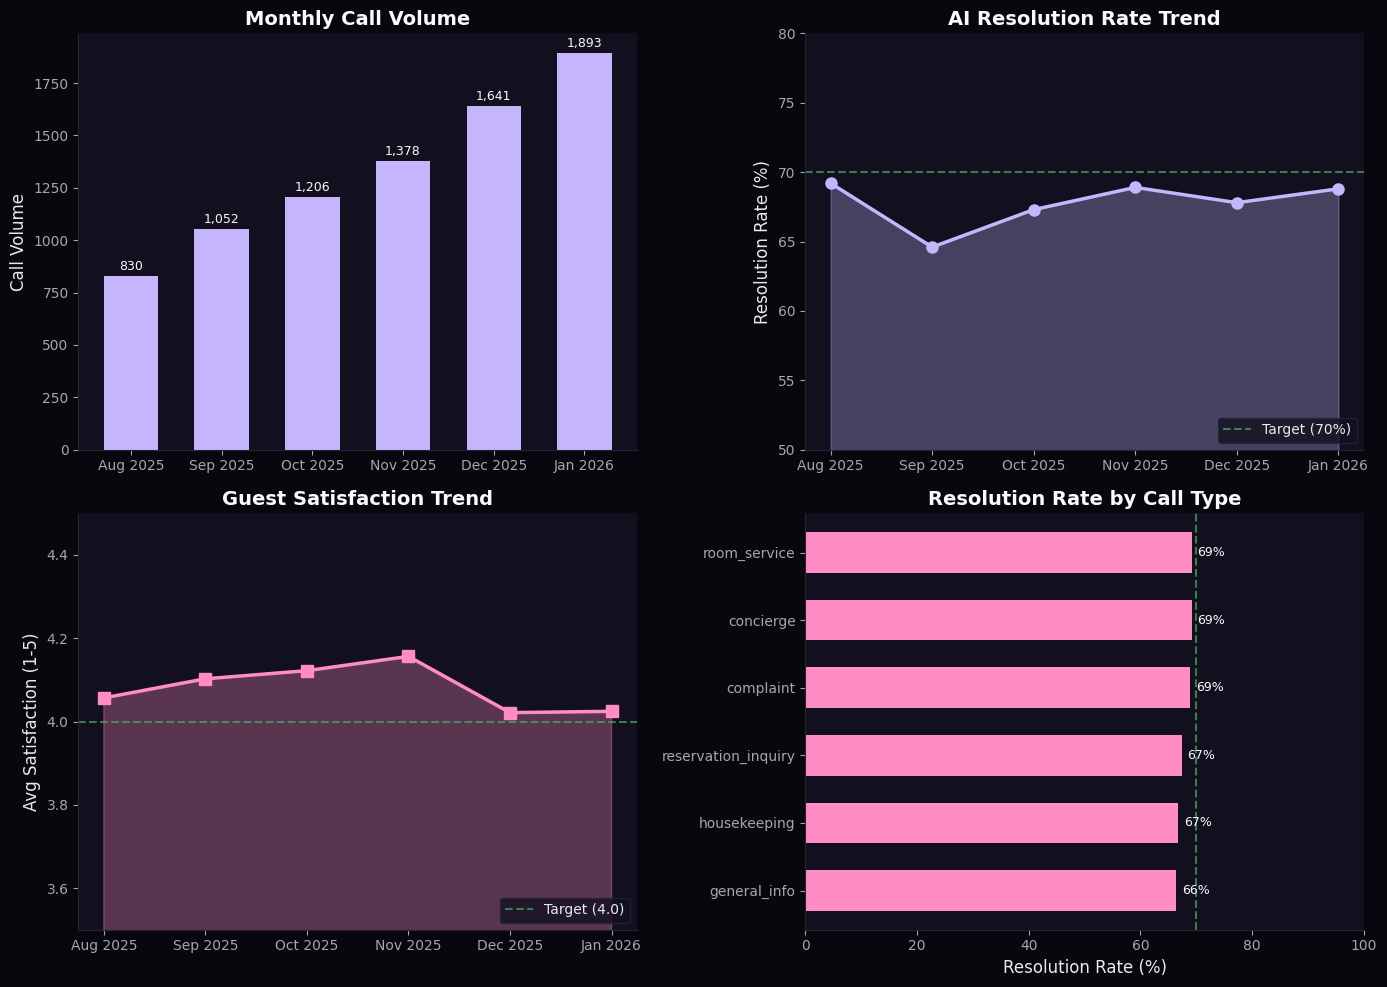

In [11]:
# Visualize AI Voice performance trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

months = df_monthly['call_month'].dt.strftime('%b %Y')

# 1. Call Volume Trend
ax1 = axes[0, 0]
ax1.bar(months, df_monthly['call_volume'], color=COLORS['primary'], width=0.6)
for i, v in enumerate(df_monthly['call_volume']):
    ax1.text(i, v + 30, f'{v:,}', ha='center', fontsize=9, color='#FAFAFA')
ax1.set_ylabel('Call Volume')
ax1.set_title('Monthly Call Volume', fontweight='bold')

# 2. Resolution Rate Trend
ax2 = axes[0, 1]
ax2.plot(months, df_monthly['resolution_rate'], color=COLORS['primary'], linewidth=2.5, marker='o', markersize=8)
ax2.fill_between(range(len(months)), df_monthly['resolution_rate'], alpha=0.3, color=COLORS['primary'])
ax2.axhline(y=70, color='#4ca86f', linestyle='--', linewidth=1.5, alpha=0.7, label='Target (70%)')
ax2.set_ylabel('Resolution Rate (%)')
ax2.set_title('AI Resolution Rate Trend', fontweight='bold')
ax2.set_ylim(50, 80)
ax2.legend(loc='lower right')

# 3. Guest Satisfaction Trend
ax3 = axes[1, 0]
ax3.plot(months, df_monthly['avg_satisfaction'], color=COLORS['secondary'], linewidth=2.5, marker='s', markersize=8)
ax3.fill_between(range(len(months)), df_monthly['avg_satisfaction'], alpha=0.3, color=COLORS['secondary'])
ax3.axhline(y=4.0, color='#4ca86f', linestyle='--', linewidth=1.5, alpha=0.7, label='Target (4.0)')
ax3.set_ylabel('Avg Satisfaction (1-5)')
ax3.set_title('Guest Satisfaction Trend', fontweight='bold')
ax3.set_ylim(3.5, 4.5)
ax3.legend(loc='lower right')

# 4. Resolution by Call Type
df_by_type = df_voice.groupby('call_type').agg(
    calls=('id', 'count'),
    resolved=('resolution_status', lambda x: (x == 'resolved').sum())
).reset_index()
df_by_type['resolution_rate'] = (df_by_type['resolved'] / df_by_type['calls'] * 100).round(1)
df_by_type = df_by_type.sort_values('resolution_rate', ascending=True)

ax4 = axes[1, 1]
colors = [COLORS['primary'] if r >= 70 else COLORS['secondary'] if r >= 60 else '#c45757' for r in df_by_type['resolution_rate']]
bars = ax4.barh(df_by_type['call_type'], df_by_type['resolution_rate'], color=colors, height=0.6)
for bar, val in zip(bars, df_by_type['resolution_rate']):
    ax4.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.0f}%', va='center', fontsize=9, color='#FAFAFA')
ax4.axvline(x=70, color='#4ca86f', linestyle='--', linewidth=1.5, alpha=0.7)
ax4.set_xlabel('Resolution Rate (%)')
ax4.set_title('Resolution Rate by Call Type', fontweight='bold')
ax4.set_xlim(0, 100)

plt.tight_layout()
plt.show()

In [12]:
# Query contracts data with property details for NRR analysis
query_nrr = """
SELECT 
    c.id,
    c.property_id,
    p.property_name,
    p.hotel_segment,
    c.event_type,
    c.event_date::date AS event_date,
    c.mrr_usd,
    c.reason
FROM public.contracts c
JOIN public.properties p ON c.property_id = p.id
ORDER BY c.property_id, c.event_date
"""

df_contracts = pd.read_sql(query_nrr, engine)
engine.dispose()

print(f"Total contract events: {len(df_contracts):,}")
print(f"Properties: {df_contracts['property_id'].nunique()}")
print(f"Date range: {df_contracts['event_date'].min()} to {df_contracts['event_date'].max()}")
print(f"\nEvent types:\n{df_contracts['event_type'].value_counts()}")
print(f"\nExpansion reasons:\n{df_contracts[df_contracts['event_type']=='expansion']['reason'].value_counts()}")

Total contract events: 526
Properties: 350
Date range: 2024-08-10 to 2026-01-26

Event types:
event_type
new            350
expansion       88
contraction     69
churn           19
Name: count, dtype: int64

Expansion reasons:
reason
room_count_increase      23
upgraded_plan            16
added_analytics          13
added_voice              13
added_upsell             10
added_mobile_checkin      9
annual_price_increase     4
Name: count, dtype: int64


In [13]:
# Calculate NRR by hotel segment
# NRR = (Starting MRR + Expansion - Contraction - Churn) / Starting MRR * 100

# Get starting MRR (sum of 'new' events) by segment
starting_mrr = df_contracts[df_contracts['event_type'] == 'new'].groupby('hotel_segment')['mrr_usd'].sum()

# Get expansion, contraction, churn by segment
expansion = df_contracts[df_contracts['event_type'] == 'expansion'].groupby('hotel_segment')['mrr_usd'].sum()
contraction = df_contracts[df_contracts['event_type'] == 'contraction'].groupby('hotel_segment')['mrr_usd'].sum()
churn = df_contracts[df_contracts['event_type'] == 'churn'].groupby('hotel_segment')['mrr_usd'].sum()

# Build NRR dataframe
df_nrr = pd.DataFrame({
    'starting_mrr': starting_mrr,
    'expansion': expansion,
    'contraction': contraction,
    'churn': churn
}).fillna(0)

df_nrr['ending_mrr'] = df_nrr['starting_mrr'] + df_nrr['expansion'] - df_nrr['contraction'] - df_nrr['churn']
df_nrr['nrr'] = (df_nrr['ending_mrr'] / df_nrr['starting_mrr'] * 100).round(1)
df_nrr['net_change'] = df_nrr['expansion'] - df_nrr['contraction'] - df_nrr['churn']

# Count properties by segment
prop_counts = df_contracts[df_contracts['event_type'] == 'new'].groupby('hotel_segment').size()
df_nrr['properties'] = prop_counts

df_nrr = df_nrr.sort_values('nrr', ascending=False).reset_index()
df_nrr.columns = ['Segment', 'Starting MRR', 'Expansion', 'Contraction', 'Churn', 'Ending MRR', 'NRR %', 'Net Change', 'Properties']

# Format for display
df_nrr_display = df_nrr.copy()
for col in ['Starting MRR', 'Expansion', 'Contraction', 'Churn', 'Ending MRR', 'Net Change']:
    df_nrr_display[col] = df_nrr_display[col].apply(lambda x: f"${x:,.0f}")

print("═" * 70)
print("NET REVENUE RETENTION (NRR) BY HOTEL SEGMENT")
print("═" * 70)
df_nrr_display

══════════════════════════════════════════════════════════════════════
NET REVENUE RETENTION (NRR) BY HOTEL SEGMENT
══════════════════════════════════════════════════════════════════════


,Segment,Starting MRR,Expansion,Contraction,Churn,Ending MRR,NRR %,Net Change,Properties
0,luxury,"$109,271","$21,095","$-2,003","$-2,701","$135,071",123.6,"$25,799",40
1,midscale,"$82,555","$6,354","$-3,040","$-7,442","$99,392",120.4,"$16,837",100
2,upper_upscale,"$150,635","$20,627","$-2,959","$-5,618","$179,838",119.4,"$29,204",80
3,upscale,"$158,897","$12,311","$-2,477","$-6,656","$180,342",113.5,"$21,444",130


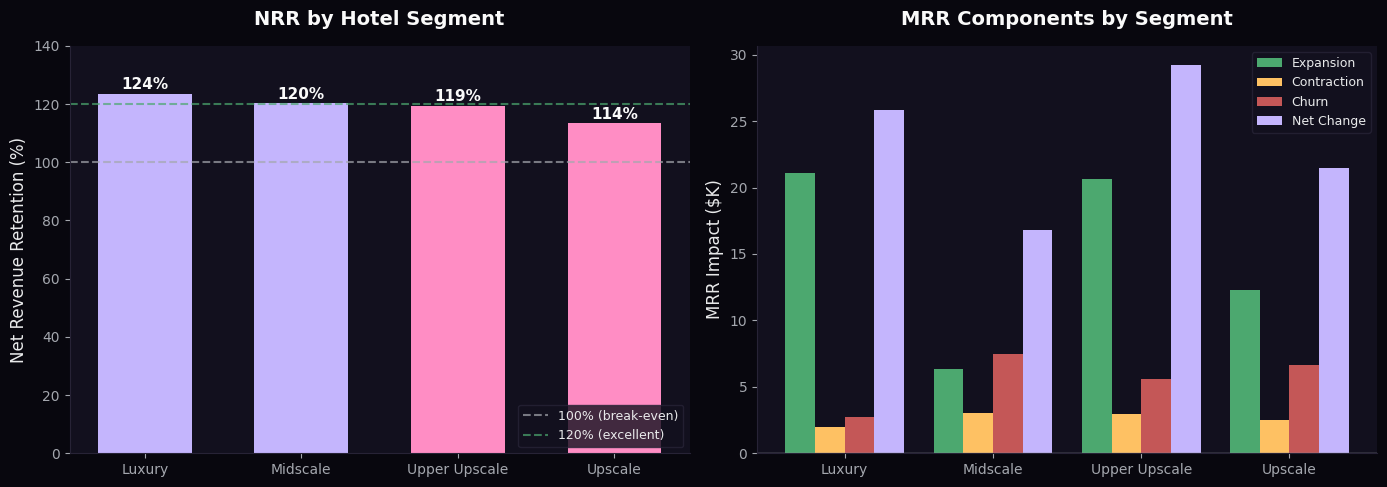

In [15]:
# NRR visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. NRR by Segment
ax1 = axes[0]
segments = df_nrr['Segment'].str.replace('_', ' ').str.title()
nrr_values = df_nrr['NRR %']
colors = ['#c4b5fd' if n >= 120 else '#ff8dc4' if n >= 110 else '#c45757' for n in nrr_values]

bars = ax1.bar(segments, nrr_values, color=colors, width=0.6)
ax1.axhline(y=100, color='#a4a7ae', linestyle='--', linewidth=1.5, alpha=0.7, label='100% (break-even)')
ax1.axhline(y=120, color='#4ca86f', linestyle='--', linewidth=1.5, alpha=0.7, label='120% (excellent)')

for bar, val in zip(bars, nrr_values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 1.5, f'{val:.0f}%', ha='center', fontsize=11, fontweight='bold', color='#FAFAFA')

ax1.set_ylabel('Net Revenue Retention (%)')
ax1.set_title('NRR by Hotel Segment', fontweight='bold', pad=15)
ax1.set_ylim(0, 140)
ax1.legend(loc='lower right', fontsize=9)

# 2. MRR Waterfall components
ax2 = axes[1]
x = np.arange(len(segments))
width = 0.2

ax2.bar(x - width*1.5, df_nrr['Expansion']/1000, width, label='Expansion', color='#4ca86f')
ax2.bar(x - width*0.5, -df_nrr['Contraction']/1000, width, label='Contraction', color='#fec163')
ax2.bar(x + width*0.5, -df_nrr['Churn']/1000, width, label='Churn', color='#c45757')
ax2.bar(x + width*1.5, df_nrr['Net Change']/1000, width, label='Net Change', color='#c4b5fd')

ax2.axhline(y=0, color='#a4a7ae', linewidth=1)
ax2.set_xticks(x)
ax2.set_xticklabels(segments)
ax2.set_ylabel('MRR Impact ($K)')
ax2.set_title('MRR Components by Segment', fontweight='bold', pad=15)
ax2.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

In [16]:
# Identify top expanding and contracting accounts
df_expanding = df_contracts[df_contracts['event_type'] == 'expansion'].groupby(
    ['property_id', 'property_name', 'hotel_segment']
)['mrr_usd'].sum().reset_index().sort_values('mrr_usd', ascending=False).head(10)
df_expanding.columns = ['Property ID', 'Property Name', 'Segment', 'Expansion MRR']

df_contracting = df_contracts[df_contracts['event_type'].isin(['contraction', 'churn'])].groupby(
    ['property_id', 'property_name', 'hotel_segment']
)['mrr_usd'].sum().reset_index().sort_values('mrr_usd', ascending=True).head(10)
df_contracting.columns = ['Property ID', 'Property Name', 'Segment', 'Lost MRR']

print("═" * 60)
print("TOP 10 EXPANDING ACCOUNTS")
print("═" * 60)
for _, row in df_expanding.iterrows():
    print(f"  +${row['Expansion MRR']:,.0f}  {row['Property Name'][:35]:<35} ({row['Segment']})")

print("\n" + "═" * 60)
print("TOP 10 CONTRACTING/CHURNED ACCOUNTS")
print("═" * 60)
for _, row in df_contracting.iterrows():
    print(f"  -${abs(row['Lost MRR']):,.0f}  {row['Property Name'][:35]:<35} ({row['Segment']})")

════════════════════════════════════════════════════════════
TOP 10 EXPANDING ACCOUNTS
════════════════════════════════════════════════════════════
  +$2,331  Grand Houston Tech Center           (luxury)
  +$2,290  Conrad Denver Midtown               (upper_upscale)
  +$2,199  The St. Regis Columbus & Conference (luxury)
  +$2,015  Sheraton New Orleans Tech Center    (upper_upscale)
  +$1,970  Edition Jacksonville & Conference C (luxury)
  +$1,925  Sofitel Portland Riverwalk          (upper_upscale)
  +$1,538  Mandarin Oriental Boston Waterfront (luxury)
  +$1,521  The Langham Tampa Galleria          (luxury)
  +$1,497  The St. Regis Denver Resort & Spa   (luxury)
  +$1,412  Embassy Suites Louisville Downtown  (upscale)

════════════════════════════════════════════════════════════
TOP 10 CONTRACTING/CHURNED ACCOUNTS
════════════════════════════════════════════════════════════
  -$2,701  Fairmont Orlando Beach Resort       (luxury)
  -$2,491  Pullman Indianapolis University     (upper_u